In [1]:
pip install DeepXDE

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import numpy as np
import deepxde as dde
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import pandas as pd
from IPython.display import display
import tensorflow as tf

import skopt
from skopt import gp_minimize
from skopt.plots import plot_convergence, plot_objective
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args

2024-08-05 18:56:56.008758: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-05 18:56:57.845191: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-05 18:57:04.252030: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Instructions for updating:
non-resource variables are not supported in the long term


Enable just-in-time compilation with XLA.



In [3]:
x_lower = -25
x_upper = 25
t_lower = 0
t_upper = 1

α = 0
β = 0

α_0 = 0
k = 1
ω = 0.88
x_0 = 0
θ_0 = 0
μ = 4 * (k ** 2 - ω)

x = np.linspace(x_lower, x_upper, 256)
t = np.linspace(t_lower, t_upper, 201)
X, T = np.meshgrid(x, t)

X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

space_domain = dde.geometry.Interval(x_lower, x_upper)
time_domain = dde.geometry.TimeDomain(t_lower, t_upper)
geomtime = dde.geometry.GeometryXTime(space_domain, time_domain)

In [4]:
def pde(x, y):
    u = y[:, 0:1]
    v = y[:, 1:2]

    u_t = dde.grad.jacobian(y, x, i=0, j=1)
    v_t = dde.grad.jacobian(y, x, i=1, j=1)

    u_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    v_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)

    f_u = -v_t + u_xx + u * (u ** 2 + v ** 2) * (1 - α * (u ** 2 + v ** 2) + β * (u ** 2 + v ** 2) ** 2)
    f_v = u_t + v_xx + v * (u ** 2 + v ** 2) * (1 - α * (u ** 2 + v ** 2) + β * (u ** 2 + v ** 2) ** 2)

    return [f_u, f_v]

In [5]:
bc_u_0 = dde.icbc.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=0
)
bc_u_1 = dde.icbc.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=0
)
bc_v_0 = dde.icbc.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=1
)
bc_v_1 = dde.icbc.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=1
)


def init_cond_u(x):
    return np.cos(k * x[:, 0:1] + θ_0) * np.sqrt(μ * np.exp((x[:, 0:1] - x_0) * np.sqrt(μ)) / (
                ((1 / 2) * np.exp((x[:, 0:1] - x_0) * np.sqrt(μ)) + 1) ** 2 - (α_0 * μ / 3) * np.exp(
            2 * (x[:, 0:1] - x_0) * np.sqrt(μ))))


def init_cond_v(x):
    return np.sin(k * x[:, 0:1] + θ_0) * np.sqrt(μ * np.exp((x[:, 0:1] - x_0) * np.sqrt(μ)) / (
                ((1 / 2) * np.exp((x[:, 0:1] - x_0) * np.sqrt(μ)) + 1) ** 2 - (α_0 * μ / 3) * np.exp(
            2 * (x[:, 0:1] - x_0) * np.sqrt(μ))))


ic_u = dde.icbc.IC(geomtime, init_cond_u, lambda _, on_initial: on_initial, component=0)
ic_v = dde.icbc.IC(geomtime, init_cond_v, lambda _, on_initial: on_initial, component=1)

In [6]:
def create_model(config):
    num_domain_, num_boundary_, num_initial_, learning_rate, num_dense_layers, num_dense_nodes, activation = config

    data = dde.data.TimePDE(
        geomtime,
        pde,
        [bc_u_0, bc_u_1, bc_v_0, bc_v_1, ic_u, ic_v],
         num_domain=num_domain_,
         num_boundary=num_boundary_,
         num_initial=num_initial_,
         train_distribution="pseudo"
    )

    net = dde.nn.FNN([2] + [num_dense_nodes] * num_dense_layers + [2], activation, "Glorot normal")

    model = dde.Model(data, net)
    model.compile("adam", lr=learning_rate, loss="MSE")
    return model

In [7]:
def train_model(model, config):
    losshistory, train_state = model.train(iterations=10000)
    train = np.array(losshistory.loss_train).sum(axis=1).ravel()
    test = np.array(losshistory.loss_test).sum(axis=1).ravel()
    metric = np.array(losshistory.metrics_test).sum(axis=1).ravel()

    error = test.min()
    return error

In [8]:
# HPO setting
n_calls = 11
dim_num_domain_ = Integer(low=10000, high=30000, name="num_domain_")
dim_num_boundary_ = Integer(low=1, high=1000, name="num_boundary_")
dim_num_initial_ = Integer(low=1, high=5000, name="num_initial_")
dim_learning_rate = Real(low=1e-4, high=5e-2, name="learning_rate", prior="log-uniform")
dim_num_dense_layers = Integer(low=1, high=4, name="num_dense_layers")
dim_num_dense_nodes = Integer(low=5, high=100, name="num_dense_nodes")
dim_activation = Categorical(categories=["sin", "sigmoid", "tanh"], name="activation")

dimensions = [
    dim_num_domain_,
    dim_num_boundary_,
    dim_num_initial_,
    dim_learning_rate,
    dim_num_dense_layers,
    dim_num_dense_nodes,
    dim_activation,
]

default_parameters = [10000, 20, 200, 1e-3, 2, 32, "sin"]

In [9]:
@use_named_args(dimensions=dimensions)
def fitness(num_domain_, num_boundary_, num_initial_, learning_rate, num_dense_layers, num_dense_nodes, activation):
    config = [num_domain_, num_boundary_, num_initial_, learning_rate, num_dense_layers, num_dense_nodes, activation]
    global ITERATION

    print(ITERATION, "it number")
    print("num_domain:", num_domain_)
    print("num_boundary:", num_boundary_)
    print("num_initial:", num_initial_)
    print("learning rate: {0:.1e}".format(learning_rate))
    print("num_dense_layers:", num_dense_layers)
    print("num_dense_nodes:", num_dense_nodes)
    print("activation:", activation)
    print()

    model = create_model(config)
    error = train_model(model, config)

    if np.isnan(error):
        error = 10**5

    ITERATION += 1
    return error

0 it number
num_domain: 10000
num_boundary: 20
num_initial: 200
learning rate: 1.0e-03
num_dense_layers: 2
num_dense_nodes: 32
activation: sin

Compiling model...
Building feed-forward neural network...
'build' took 0.046910 s



/home/jupyter/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
/home/jupyter/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
/home/jupyter/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2024-08-05 18:57:48.614595: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-08-05 18:57:48.614642: I tens

'compile' took 1.115295 s



2024-08-05 18:57:49.536135: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled


Training model...



2024-08-05 18:57:50.005759: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fb4e8003340 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-05 18:57:50.005810: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-08-05 18:57:50.296037: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-05 18:57:51.020888: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2024-08-05 18:57:53.151229: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step      Train loss                                                                          Test loss                                                                           Test metric
0         [1.34e+00, 1.52e+01, 9.07e+00, 9.71e-03, 1.54e+00, 1.19e-05, 3.52e-01, 1.25e+00]    [1.34e+00, 1.52e+01, 9.07e+00, 9.71e-03, 1.54e+00, 1.19e-05, 3.52e-01, 1.25e+00]    []  
1000      [7.20e-04, 1.53e-03, 3.38e-05, 1.39e-05, 2.17e-06, 4.27e-05, 1.08e-02, 6.74e-03]    [7.20e-04, 1.53e-03, 3.38e-05, 1.39e-05, 2.17e-06, 4.27e-05, 1.08e-02, 6.74e-03]    []  
2000      [5.12e-04, 2.46e-03, 8.27e-06, 4.20e-06, 3.42e-06, 1.86e-05, 8.16e-03, 3.55e-03]    [5.12e-04, 2.46e-03, 8.27e-06, 4.20e-06, 3.42e-06, 1.86e-05, 8.16e-03, 3.55e-03]    []  
3000      [7.09e-04, 1.73e-03, 1.71e-06, 7.94e-06, 6.86e-07, 6.15e-06, 3.06e-03, 2.05e-03]    [7.09e-04, 1.73e-03, 1.71e-06, 7.94e-06, 6.86e-07, 6.15e-06, 3.06e-03, 2.05e-03]    []  
4000      [6.78e-04, 6.19e-04, 1.43e-06, 2.72e-05, 1.14e-06, 2.01e-06, 6.13e-0

/home/jupyter/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
/home/jupyter/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
/home/jupyter/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
/home/jupyter/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.356018 s

Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
0         [1.83e+00, 1.20e+00, 1.67e+00, 1.85e-03, 3.46e+00, 2.30e-04, 4.80e-01, 4.43e-01]    [1.83e+00, 1.20e+00, 1.67e+00, 1.85e-03, 3.46e+00, 2.30e-04, 4.80e-01, 4.43e-01]    []  
1000      [4.46e-04, 4.81e-04, 6.49e-06, 1.72e-06, 4.24e-06, 5.42e-06, 1.57e-04, 3.22e-04]    [4.46e-04, 4.81e-04, 6.49e-06, 1.72e-06, 4.24e-06, 5.42e-06, 1.57e-04, 3.22e-04]    []  
2000      [1.21e-04, 1.14e-04, 6.01e-07, 4.71e-07, 2.06e-07, 4.25e-06, 1.26e-05, 4.06e-05]    [1.21e-04, 1.14e-04, 6.01e-07, 4.71e-07, 2.06e-07, 4.25e-06, 1.26e-05, 4.06e-05]    []  
3000      [4.57e-05, 3.66e-05, 4.01e-08, 4.55e-07, 6.59e-07, 2.17e-06, 3.64e-06, 9.22e-06]    [4.57e-05, 3.66e-05, 4.01e-08, 4.55e-07, 6.59e-07, 2.17e-06, 3.64e-06, 9.22e-06]    []  
4000      [2.36e-05, 1.60e-05, 1

/home/jupyter/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
/home/jupyter/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
/home/jupyter/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2024-08-05 18:59:37.673748: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13944 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:8c:00.0, compute capability: 7.5


'compile' took 0.833130 s

Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
0         [3.90e-02, 2.46e+00, 1.25e-01, 2.59e-06, 6.68e+00, 1.87e-07, 4.67e-02, 1.20e+00]    [3.90e-02, 2.46e+00, 1.25e-01, 2.59e-06, 6.68e+00, 1.87e-07, 4.67e-02, 1.20e+00]    []  
1000      [6.15e-04, 1.71e-04, 2.51e-05, 2.02e-06, 1.48e-06, 1.89e-07, 1.08e-02, 1.41e-02]    [6.15e-04, 1.71e-04, 2.51e-05, 2.02e-06, 1.48e-06, 1.89e-07, 1.08e-02, 1.41e-02]    []  
2000      [1.20e-04, 6.26e-05, 1.06e-05, 1.33e-06, 1.00e-05, 9.16e-07, 9.91e-03, 1.13e-02]    [1.20e-04, 6.26e-05, 1.06e-05, 1.33e-06, 1.00e-05, 9.16e-07, 9.91e-03, 1.13e-02]    []  
3000      [2.55e-04, 7.12e-05, 5.11e-06, 1.86e-07, 4.88e-07, 1.12e-06, 8.64e-03, 9.77e-03]    [2.55e-04, 7.12e-05, 5.11e-06, 1.86e-07, 4.88e-07, 1.12e-06, 8.64e-03, 9.77e-03]    []  
4000      [6.10e-04, 9.09e-05, 2

/home/jupyter/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
/home/jupyter/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
/home/jupyter/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2024-08-05 19:00:36.429528: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13944 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:8c:00.0, compute capability: 7.5


'compile' took 0.858625 s

Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
0         [1.14e+00, 3.62e-01, 3.92e+00, 1.29e-06, 8.94e-01, 1.21e-06, 8.43e-01, 2.61e-01]    [1.14e+00, 3.62e-01, 3.92e+00, 1.29e-06, 8.94e-01, 1.21e-06, 8.43e-01, 2.61e-01]    []  
1000      [1.16e-03, 1.13e-03, 2.68e-05, 1.28e-06, 4.06e-05, 2.86e-08, 1.01e-02, 9.16e-03]    [1.16e-03, 1.13e-03, 2.68e-05, 1.28e-06, 4.06e-05, 2.86e-08, 1.01e-02, 9.16e-03]    []  
2000      [7.66e-04, 1.49e-03, 2.17e-06, 1.23e-06, 7.41e-07, 8.77e-08, 8.75e-03, 7.03e-03]    [7.66e-04, 1.49e-03, 2.17e-06, 1.23e-06, 7.41e-07, 8.77e-08, 8.75e-03, 7.03e-03]    []  
3000      [6.40e-04, 1.29e-03, 9.79e-07, 3.00e-07, 5.05e-07, 6.26e-07, 7.57e-03, 6.29e-03]    [6.40e-04, 1.29e-03, 9.79e-07, 3.00e-07, 5.05e-07, 6.26e-07, 7.57e-03, 6.29e-03]    []  
4000      [6.73e-04, 1.05e-03, 1

/home/jupyter/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
/home/jupyter/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
/home/jupyter/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2024-08-05 19:01:15.545765: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13944 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:8c:00.0, compute capability: 7.5


'compile' took 0.897300 s

Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
0         [1.99e-02, 3.76e-02, 6.88e-01, 7.97e-06, 3.80e-01, 2.83e-06, 1.60e-01, 6.17e-02]    [1.99e-02, 3.76e-02, 6.88e-01, 7.97e-06, 3.80e-01, 2.83e-06, 1.60e-01, 6.17e-02]    []  
1000      [6.14e-04, 4.66e-04, 7.05e-07, 3.74e-07, 3.04e-06, 3.55e-06, 1.86e-03, 1.79e-03]    [6.14e-04, 4.66e-04, 7.05e-07, 3.74e-07, 3.04e-06, 3.55e-06, 1.86e-03, 1.79e-03]    []  
2000      [2.77e-04, 2.30e-04, 3.31e-06, 1.04e-05, 3.14e-07, 6.80e-07, 6.94e-04, 6.41e-04]    [2.77e-04, 2.30e-04, 3.31e-06, 1.04e-05, 3.14e-07, 6.80e-07, 6.94e-04, 6.41e-04]    []  
3000      [1.28e-04, 1.33e-04, 2.70e-07, 2.71e-06, 1.04e-06, 4.74e-07, 3.62e-04, 3.40e-04]    [1.28e-04, 1.33e-04, 2.70e-07, 2.71e-06, 1.04e-06, 4.74e-07, 3.62e-04, 3.40e-04]    []  
4000      [9.07e-05, 8.55e-05, 7

/home/jupyter/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
/home/jupyter/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2024-08-05 19:02:48.220563: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13944 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:8c:00.0, compute capability: 7.5


'compile' took 0.798130 s

Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
0         [6.97e-04, 3.54e-03, 9.96e-03, 4.91e-08, 3.55e-01, 1.71e-06, 4.92e-02, 6.05e-02]    [6.97e-04, 3.54e-03, 9.96e-03, 4.91e-08, 3.55e-01, 1.71e-06, 4.92e-02, 6.05e-02]    []  
1000      [1.33e-05, 4.09e-05, 1.14e-06, 4.12e-08, 7.16e-07, 2.75e-08, 1.31e-02, 1.27e-02]    [1.33e-05, 4.09e-05, 1.14e-06, 4.12e-08, 7.16e-07, 2.75e-08, 1.31e-02, 1.27e-02]    []  
2000      [4.84e-04, 8.07e-04, 1.29e-08, 2.36e-06, 1.04e-06, 6.31e-07, 4.76e-03, 5.14e-03]    [4.84e-04, 8.07e-04, 1.29e-08, 2.36e-06, 1.04e-06, 6.31e-07, 4.76e-03, 5.14e-03]    []  
3000      [5.73e-04, 9.10e-04, 2.31e-03, 3.13e-08, 3.03e-03, 3.28e-07, 2.96e-03, 3.96e-03]    [5.73e-04, 9.10e-04, 2.31e-03, 3.13e-08, 3.03e-03, 3.28e-07, 2.96e-03, 3.96e-03]    []  
4000      [5.44e-04, 6.13e-04, 3

/home/jupyter/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
/home/jupyter/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2024-08-05 19:03:26.790607: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13944 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:8c:00.0, compute capability: 7.5


'compile' took 0.800836 s

Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
0         [5.84e-02, 9.16e-02, 5.55e-01, 1.77e-07, 2.47e+00, 1.08e-05, 7.36e-02, 2.58e-01]    [5.84e-02, 9.16e-02, 5.55e-01, 1.77e-07, 2.47e+00, 1.08e-05, 7.36e-02, 2.58e-01]    []  
1000      [4.07e-04, 5.07e-04, 2.24e-06, 2.17e-05, 1.25e-06, 3.51e-07, 1.85e-03, 2.39e-03]    [4.07e-04, 5.07e-04, 2.24e-06, 2.17e-05, 1.25e-06, 3.51e-07, 1.85e-03, 2.39e-03]    []  
2000      [2.48e-04, 2.35e-04, 1.73e-07, 1.12e-07, 3.94e-06, 9.15e-07, 5.48e-04, 7.74e-04]    [2.48e-04, 2.35e-04, 1.73e-07, 1.12e-07, 3.94e-06, 9.15e-07, 5.48e-04, 7.74e-04]    []  
3000      [1.69e-04, 1.78e-04, 9.56e-04, 2.15e-06, 1.01e-03, 1.86e-06, 4.83e-04, 5.64e-04]    [1.69e-04, 1.78e-04, 9.56e-04, 2.15e-06, 1.01e-03, 1.86e-06, 4.83e-04, 5.64e-04]    []  
4000      [1.16e-04, 1.12e-04, 3

/home/jupyter/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
/home/jupyter/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
/home/jupyter/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2024-08-05 19:04:27.735499: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13944 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:8c:00.0, compute capability: 7.5


'compile' took 0.946304 s

Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
0         [9.87e+00, 1.70e+02, 1.83e+00, 1.65e-05, 2.43e+01, 6.99e-06, 2.67e-01, 4.80e+00]    [9.87e+00, 1.70e+02, 1.83e+00, 1.65e-05, 2.43e+01, 6.99e-06, 2.67e-01, 4.80e+00]    []  
1000      [3.31e-04, 5.50e-04, 1.23e-05, 4.45e-06, 2.81e-05, 2.79e-06, 9.81e-03, 1.04e-02]    [3.31e-04, 5.50e-04, 1.23e-05, 4.45e-06, 2.81e-05, 2.79e-06, 9.81e-03, 1.04e-02]    []  
2000      [5.68e-04, 4.64e-04, 3.05e-06, 2.07e-06, 1.17e-06, 4.63e-06, 6.52e-03, 7.48e-03]    [5.68e-04, 4.64e-04, 3.05e-06, 2.07e-06, 1.17e-06, 4.63e-06, 6.52e-03, 7.48e-03]    []  
3000      [6.80e-04, 4.90e-04, 5.23e-06, 1.41e-05, 1.82e-06, 1.31e-07, 4.34e-03, 5.13e-03]    [6.80e-04, 4.90e-04, 5.23e-06, 1.41e-05, 1.82e-06, 1.31e-07, 4.34e-03, 5.13e-03]    []  
4000      [7.65e-04, 4.67e-04, 3

/home/jupyter/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
/home/jupyter/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2024-08-05 19:06:15.201582: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13944 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:8c:00.0, compute capability: 7.5


'compile' took 0.897905 s

Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
0         [3.85e-01, 4.92e-01, 6.71e-01, 6.03e-07, 7.78e-02, 1.66e-06, 3.83e-01, 5.86e-01]    [3.85e-01, 4.92e-01, 6.71e-01, 6.03e-07, 7.78e-02, 1.66e-06, 3.83e-01, 5.86e-01]    []  
1000      [2.99e-05, 1.85e-04, 1.84e-05, 1.24e-06, 3.15e-06, 7.04e-07, 1.31e-02, 1.39e-02]    [2.99e-05, 1.85e-04, 1.84e-05, 1.24e-06, 3.15e-06, 7.04e-07, 1.31e-02, 1.39e-02]    []  
2000      [1.71e-05, 2.00e-05, 7.60e-06, 7.03e-07, 1.91e-06, 5.26e-07, 1.28e-02, 1.34e-02]    [1.71e-05, 2.00e-05, 7.60e-06, 7.03e-07, 1.91e-06, 5.26e-07, 1.28e-02, 1.34e-02]    []  
3000      [1.56e-05, 2.27e-05, 2.23e-06, 6.30e-07, 7.36e-07, 2.97e-07, 1.26e-02, 1.30e-02]    [1.56e-05, 2.27e-05, 2.23e-06, 6.30e-07, 7.36e-07, 2.97e-07, 1.26e-02, 1.30e-02]    []  
4000      [2.46e-05, 4.67e-05, 4

/home/jupyter/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
/home/jupyter/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
/home/jupyter/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
/home/jupyter/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.225980 s

Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
0         [2.03e+00, 7.71e-01, 4.71e-01, 6.59e-06, 2.00e+00, 1.21e-04, 5.21e-01, 3.71e-01]    [2.03e+00, 7.71e-01, 4.71e-01, 6.59e-06, 2.00e+00, 1.21e-04, 5.21e-01, 3.71e-01]    []  
1000      [2.29e-04, 2.06e-04, 3.50e-06, 7.63e-07, 3.01e-06, 5.84e-07, 8.62e-05, 4.38e-05]    [2.29e-04, 2.06e-04, 3.50e-06, 7.63e-07, 3.01e-06, 5.84e-07, 8.62e-05, 4.38e-05]    []  
2000      [3.91e-05, 5.01e-05, 1.08e-07, 4.34e-07, 8.38e-08, 5.66e-07, 9.57e-06, 7.69e-06]    [3.91e-05, 5.01e-05, 1.08e-07, 4.34e-07, 8.38e-08, 5.66e-07, 9.57e-06, 7.69e-06]    []  
3000      [3.61e-05, 4.19e-05, 1.25e-06, 6.09e-07, 1.67e-07, 1.15e-06, 8.43e-06, 7.16e-06]    [3.61e-05, 4.19e-05, 1.25e-06, 6.09e-07, 1.67e-07, 1.15e-06, 8.43e-06, 7.16e-06]    []  
4000      [1.22e-05, 1.14e-05, 2

/home/jupyter/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
/home/jupyter/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
/home/jupyter/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2024-08-05 19:07:49.400531: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13944 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:8c:00.0, compute capability: 7.5


'compile' took 1.493205 s

Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
0         [1.13e+00, 1.77e-01, 4.88e+00, 4.06e-07, 5.68e-01, 5.00e-06, 9.06e-01, 1.51e-01]    [1.13e+00, 1.77e-01, 4.88e+00, 4.06e-07, 5.68e-01, 5.00e-06, 9.06e-01, 1.51e-01]    []  
1000      [3.90e-04, 2.76e-04, 1.13e-07, 4.51e-07, 4.13e-06, 5.26e-07, 8.76e-03, 8.57e-03]    [3.90e-04, 2.76e-04, 1.13e-07, 4.51e-07, 4.13e-06, 5.26e-07, 8.76e-03, 8.57e-03]    []  
2000      [4.91e-04, 6.16e-04, 4.48e-06, 1.31e-05, 1.06e-05, 1.98e-07, 5.05e-03, 4.26e-03]    [4.91e-04, 6.16e-04, 4.48e-06, 1.31e-05, 1.06e-05, 1.98e-07, 5.05e-03, 4.26e-03]    []  
3000      [5.13e-04, 6.11e-04, 2.38e-06, 4.88e-07, 2.19e-06, 8.79e-08, 2.51e-03, 1.94e-03]    [5.13e-04, 6.11e-04, 2.38e-06, 4.88e-07, 2.19e-06, 8.79e-08, 2.51e-03, 1.94e-03]    []  
4000      [2.93e-04, 4.34e-04, 5

<Axes: >

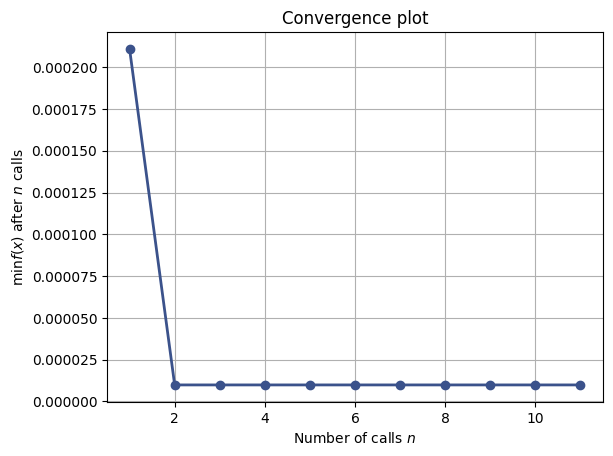

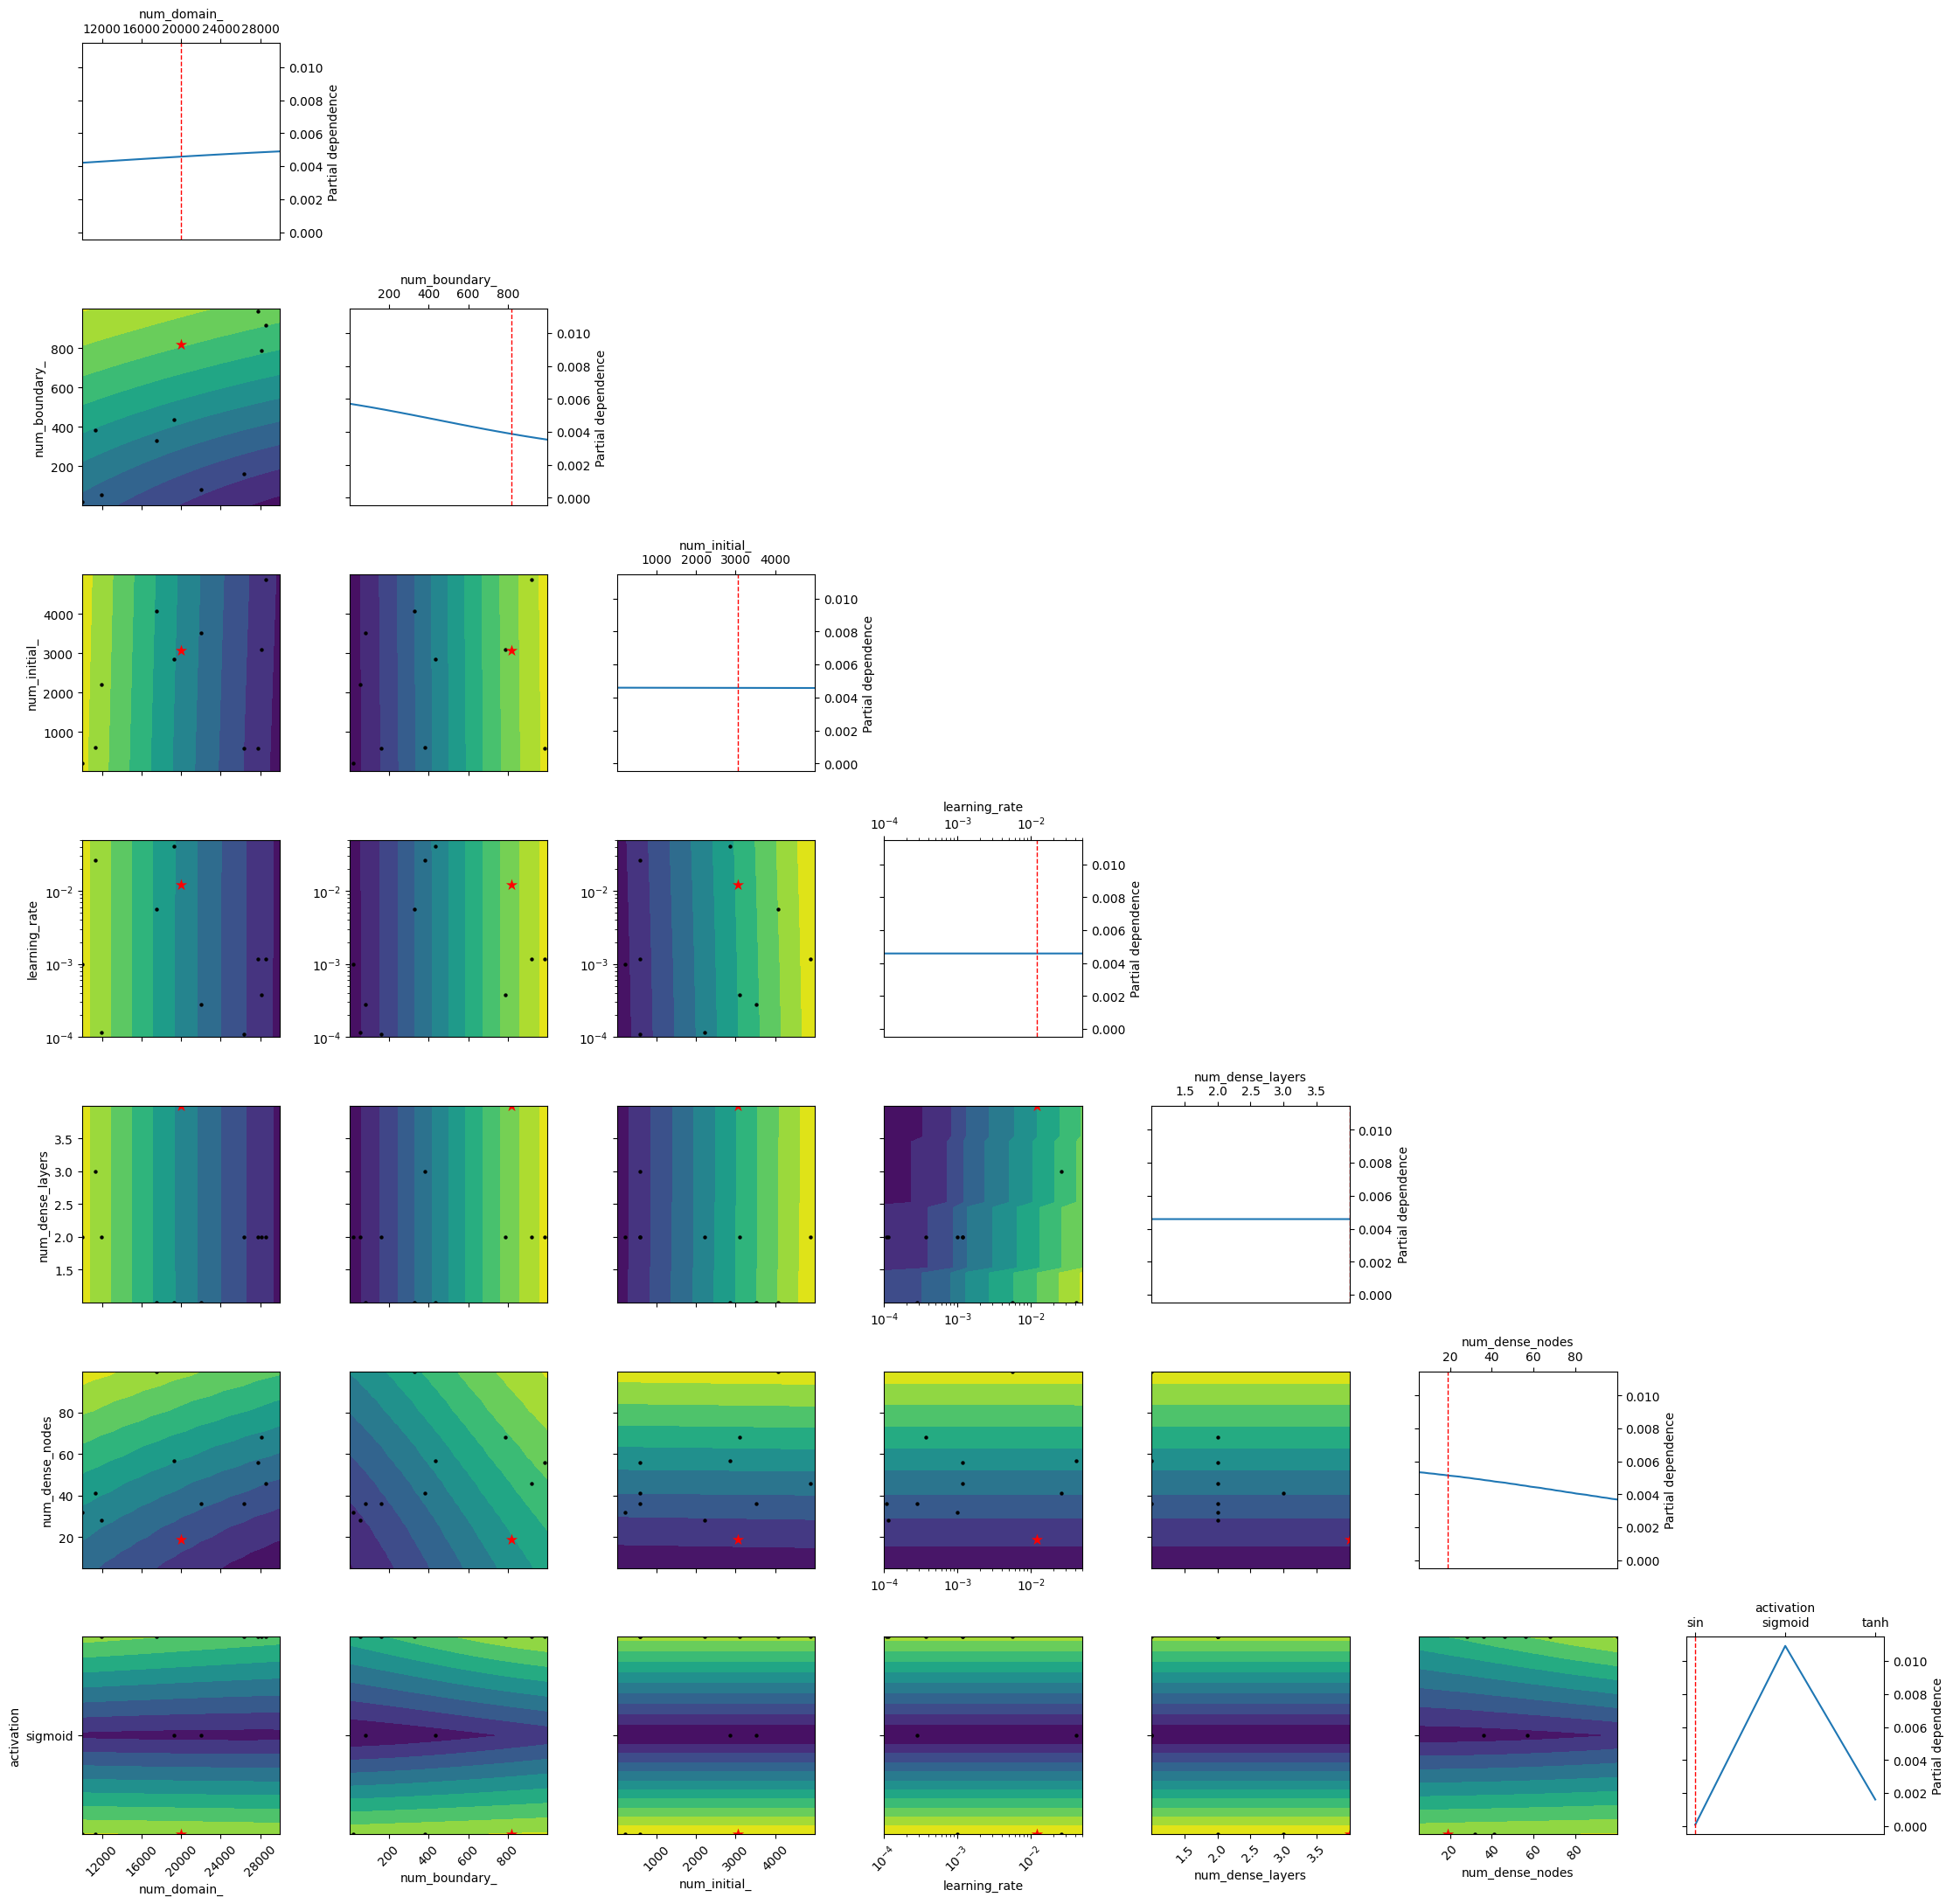

In [10]:
ITERATION = 0

search_result = gp_minimize(
    func=fitness,
    dimensions=dimensions,
    acq_func="EI",  # Expected Improvement.
    n_calls=n_calls,
    x0=default_parameters,
    random_state=1234,
)

print(search_result.x)

plot_convergence(search_result)
plot_objective(search_result, show_points=True, size=3.8)